In [6]:
import pandas as pd
import yfinance as yf

 CONFIGURATION 
TICKER = "AAPL"
STOCK_DATA_PERIOD = "5y"
EVENT_FILE = 'apple_release.xlsx' 

#1. DOWNLOAD AND PREPARE STOCK DATA 
print(f"Downloading {TICKER} stock data for the last {STOCK_DATA_PERIOD}...")
try:
    apple_^stock_df = yf.download(TICKER, period=STOCK_DATA_PERIOD)
    apple_stock_df.columns = apple_stock_df.columns.get_level_values(0)
    apple_stock_df.columns = [col.lower() for col in apple_stock_df.columns]
    
    if 'close' not in apple_stock_df.columns:
        raise KeyError("Could not find 'close' column in stock data after cleaning.")
        
    apple_stock_df.index.name = 'Date'
    
except Exception as e:
    print(f"⚠️ Error with stock data: {e}. Ensure yfinance is installed and working.")
    raise 

#  2. LOAD AND CLEAN EVENT DATA 
print("Loading and cleaning event data...")
try:
    # Use read_excel since you confirmed the file is an .xlsx
    events = pd.read_excel(EVENT_FILE)
except FileNotFoundError:
    print(f"\n❌ FATAL ERROR: File '{EVENT_FILE}' not found. Check your directory.")
    raise

events.columns = events.columns.str.strip().str.lower()
events.rename(columns={'announcenment_date': 'announcement_date'}, inplace=True) 

events['announcement_date'] = pd.to_datetime(events['announcement_date'], dayfirst=True)
events['release_date'] = pd.to_datetime(events['release_date'], dayfirst=True)

events['views'] = events['views'].astype(str).str.replace(',', '').str.strip()
events['views'] = pd.to_numeric(events['views'], errors='coerce')
events.dropna(subset=['views'], inplace=True) 

#3. PRICE LOOKUP FUNCTION ---
def get_closest_price(date, df=apple_stock_df):
    """Returns the 'close' price of the next available trading day on or after the given date."""
    if date < df.index.min() or date > df.index.max():
        return None
    
    pos = df.index.searchsorted(date, side="left")
    if pos == len(df):
        pos -= 1
        
    price = df.iloc[pos]["close"]
    return float(price)

# --- 4. CALCULATE RETURNS FOR EACH EVENT ---
print("Calculating stock returns for each event...")
results = []
for _, row in events.iterrows():
    ann_date = row['announcement_date']
    rel_date = row['release_date']
    one_month_after = rel_date + pd.Timedelta(days=30)

    ann_price = get_closest_price(ann_date)
    rel_price = get_closest_price(rel_date)
    after_price = get_closest_price(one_month_after)

    if all([price is not None for price in [ann_price, rel_price, after_price]]):
        return_ann_to_rel = (rel_price - ann_price) / ann_price * 100
        return_rel_to_1m = (after_price - rel_price) / rel_price * 100

        results.append({
            "product": row['product'],
            "views": row['views'],
            "announcement_date": ann_date,
            "release_date": rel_date,
            "return_ann_to_rel_%": return_ann_to_rel,
            "return_rel_to_1m_%": return_rel_to_1m
        })

# --- 5. FINAL RESULTS DATAFRAME ---
results_df = pd.DataFrame(results)
results_df.to_csv("apple_event_stock_analysis.csv", index=False)
print(f"\n✅ Data preparation complete. Analysis saved to apple_event_stock_analysis.csv (Rows: {len(results_df)})")

C:\Users\hoang\AppData\Local\Temp\ipykernel_54232\3449503858.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  apple_stock_df = yf.download(TICKER, period=STOCK_DATA_PERIOD)
[*********************100%***********************]  1 of 1 completed


Loading and cleaning event data...
Calculating stock returns for each event...

✅ Data preparation complete. Analysis saved to apple_event_stock_analysis.csv (Rows: 59)


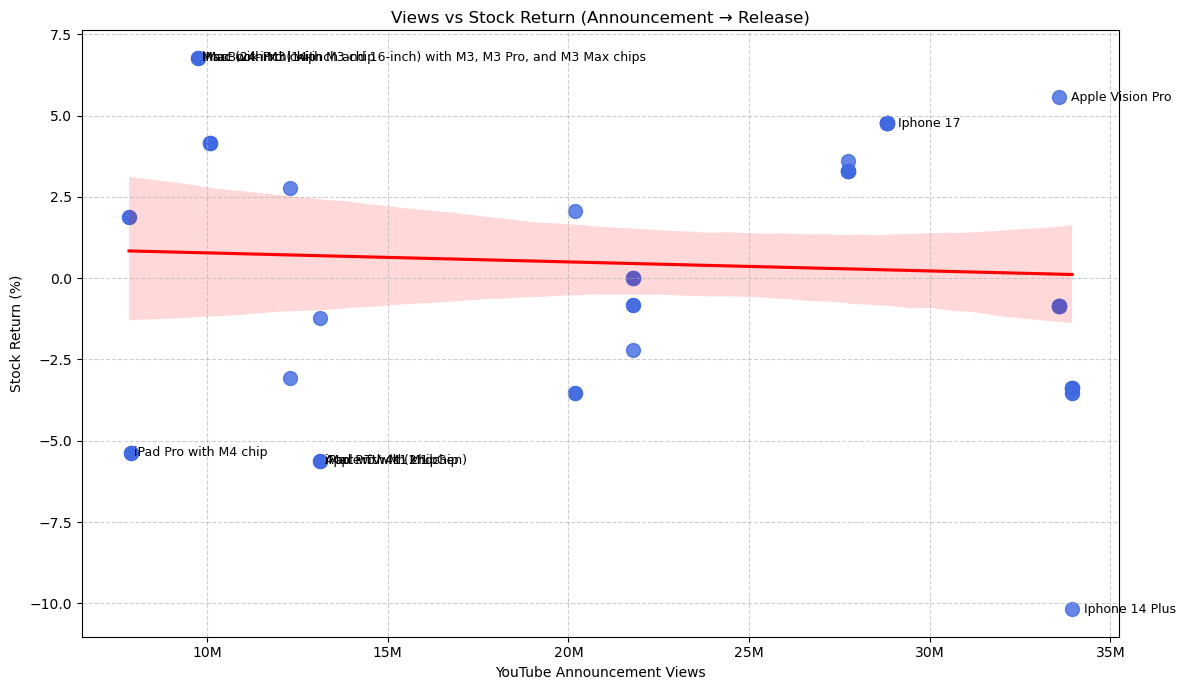


📈 Correlation between views and stock return (Announcement → Release): -0.07


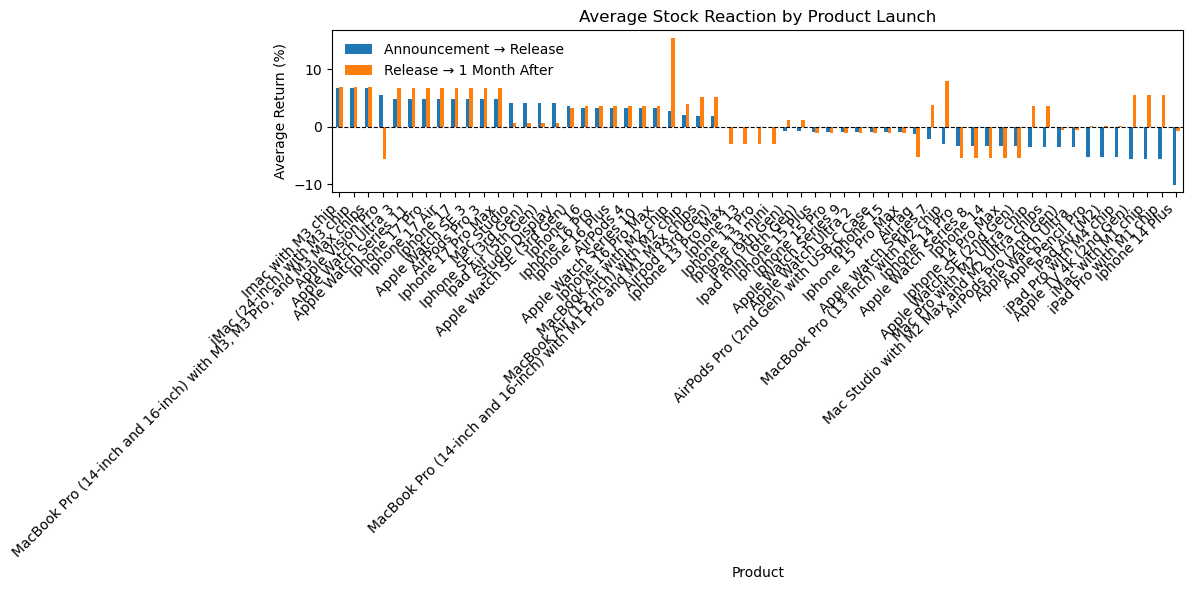

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data generated in the previous step
try:
    results_df = pd.read_csv("apple_event_stock_analysis.csv")
    for col in ['views', 'return_ann_to_rel_%', 'return_rel_to_1m_%']:
        results_df[col] = pd.to_numeric(results_df[col], errors='coerce')
    results_df.dropna(subset=['views', 'return_ann_to_rel_%'], inplace=True)
except FileNotFoundError:
    print("❌ Error: apple_event_stock_analysis.csv not found. Run the data preparation cell first.")
    raise

# --- 1. VIEWS VS. STOCK RETURN SCATTER PLOT ---
plt.figure(figsize=(12, 7))

sns.regplot(
    data=results_df,
    x='views',
    y='return_ann_to_rel_%',
    scatter=True,
    fit_reg=True,
    scatter_kws={'s': 100, 'color': 'royalblue'},
    line_kws={'color': 'red'}
)

# Label the most influential points 
highlight_points = pd.concat([
    results_df.nlargest(5, 'return_ann_to_rel_%'),
    results_df.nsmallest(5, 'return_ann_to_rel_%')
]).drop_duplicates(subset=['product'])

for i, row in highlight_points.iterrows():
    plt.text(
        row['views'] * 1.01,
        row['return_ann_to_rel_%'],
        row['product'],
        fontsize=9,
        ha='left',
        va='center'
    )

# Format x-axis in millions
formatter = plt.FuncFormatter(lambda x, pos: f'{int(x/1e6)}M')
plt.gca().xaxis.set_major_formatter(formatter)

plt.title('Views vs Stock Return (Announcement → Release)')
plt.xlabel('YouTube Announcement Views')
plt.ylabel('Stock Return (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('views_to_performance_ratio.png')
plt.show()

# --- 2. CORRELATION COEFFICIENT ---
correlation = results_df['views'].corr(results_df['return_ann_to_rel_%'])
print(f"\nCorrelation between views and stock return (Announcement → Release): {correlation:.2f}")


# --- 3. AVERAGE PRODUCT PERFORMANCE BAR CHART (TESTING FOR LONG-TERM EFFECT) ---
product_perf = results_df.groupby('product', as_index=False)[
    ['return_ann_to_rel_%', 'return_rel_to_1m_%']
].mean().sort_values('return_ann_to_rel_%', ascending=False)

product_perf.set_index('product').plot(kind='bar', figsize=(12, 6))
plt.title("Average Stock Reaction by Product Launch")
plt.ylabel("Average Return (%)")
plt.xlabel("Product")
plt.xticks(rotation=45, ha='right')
plt.legend(
    ['Announcement → Release', 'Release → 1 Month After'],
    loc='best',
    frameon=False
)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8) 
plt.tight_layout()
plt.savefig('product_performance_barchart.png')
plt.show()

C:\Users\hoang\AppData\Local\Temp\ipykernel_54232\791207129.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


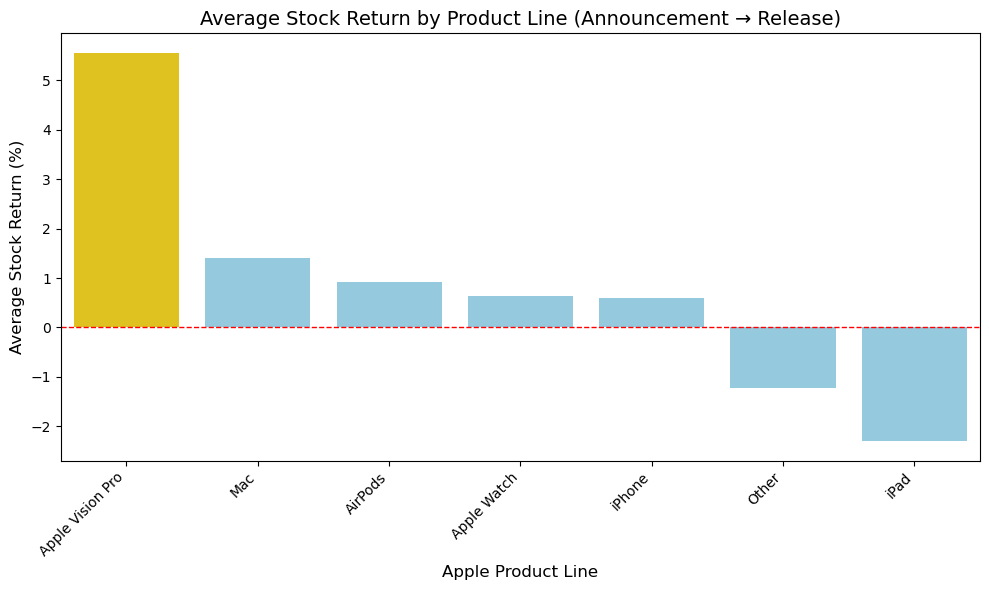


--- Best Performing Product Line (Average Return Ann. → Rel.) ---
🥇 Best Performing Product Line: Apple Vision Pro
   Average Stock Return: 5.56%

--- Full Product Line Rankings ---
Product Line Performance (Average Return %):
product_line
Apple Vision Pro    5.56
Mac                 1.41
AirPods             0.91
Apple Watch         0.63
iPhone              0.60
Other              -1.23
iPad               -2.30
Name: return_ann_to_rel_%, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
ANALYSIS_FILE = "apple_event_stock_analysis.csv"

# --- 1. LOAD AND PREPARE DATA ---
try:
    results_df = pd.read_csv(ANALYSIS_FILE)
    # Ensure columns are numeric and clean up
    for col in ['views', 'return_ann_to_rel_%', 'return_rel_to_1m_%']:
        results_df[col] = pd.to_numeric(results_df[col], errors='coerce')
    results_df.dropna(subset=['return_ann_to_rel_%', 'views'], inplace=True)
except FileNotFoundError:
    print(f"❌ Error: {ANALYSIS_FILE} not found. Please ensure your data preparation cell ran successfully.")
    # Stop execution if file is missing
    raise

# --- 2. DEFINE PRODUCT LINE INFERENCE FUNCTION ---
def infer_product_line(product_name):
    """Simplifies product name into its main line (iPhone, Mac, Watch, etc.)"""
    name = str(product_name).lower()
    
    if 'iphone' in name:
        return 'iPhone'
    if 'macbook' in name or 'imac' in name or 'mac pro' in name or 'mac studio' in name or 'mac mini' in name:
        return 'Mac'
    if 'watch' in name:
        return 'Apple Watch'
    if 'airpods' in name:
        return 'AirPods'
    if 'ipad' in name:
        return 'iPad'
    if 'homepod' in name:
        return 'HomePod'
    if 'apple vision pro' in name or 'vision' in name:
        return 'Apple Vision Pro'
    return 'Other'

results_df['product_line'] = results_df['product'].apply(infer_product_line)

# --- 3. CALCULATE PERFORMANCE METRICS ---

# Product Line Performance (Avg Return: Announcement -> Release)
line_performance = results_df.groupby('product_line')['return_ann_to_rel_%'].mean().sort_values(ascending=False).reset_index()


# --- 4. VISUALIZATION: Product Line Performance ---
plt.figure(figsize=(10, 6))

# Highlight the highest performing product line
best_line = line_performance.iloc[0]['product_line']
colors = ['gold' if line == best_line else 'skyblue' for line in line_performance['product_line']]

sns.barplot(
    data=line_performance,
    x='product_line',
    y='return_ann_to_rel_%',
    palette=colors
)
plt.title('Average Stock Return by Product Line (Announcement → Release)', fontsize=14)
plt.xlabel('Apple Product Line', fontsize=12)
plt.ylabel('Average Stock Return (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='red', linestyle='--', linewidth=1) # Zero line
plt.tight_layout()
plt.savefig('product_line_performance_visual.png')


plt.show() 
plt.close()


# --- 5. FINAL OUTPUT (Text Summary) ---
best_line_product = line_performance.iloc[0]['product_line']
best_line_return = line_performance.iloc[0]['return_ann_to_rel_%']
line_performance.set_index('product_line', inplace=True)

print("\n--- Best Performing Product Line (Average Return Ann. → Rel.) ---")
print(f"🥇 Best Performing Product Line: {best_line_product}")
print(f"   Average Stock Return: {best_line_return:.2f}%")

print("\n--- Full Product Line Rankings ---")
print("Product Line Performance (Average Return %):")
print(line_performance['return_ann_to_rel_%'].round(2))

C:\Users\hoang\AppData\Local\Temp\ipykernel_54232\2256171910.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  apple_stock_df = yf.download(TICKER, period=STOCK_DATA_PERIOD)
[*********************100%***********************]  1 of 1 completed
C:\Users\hoang\AppData\Local\Temp\ipykernel_54232\2256171910.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Calculating annual returns (First Open to Last Close)...


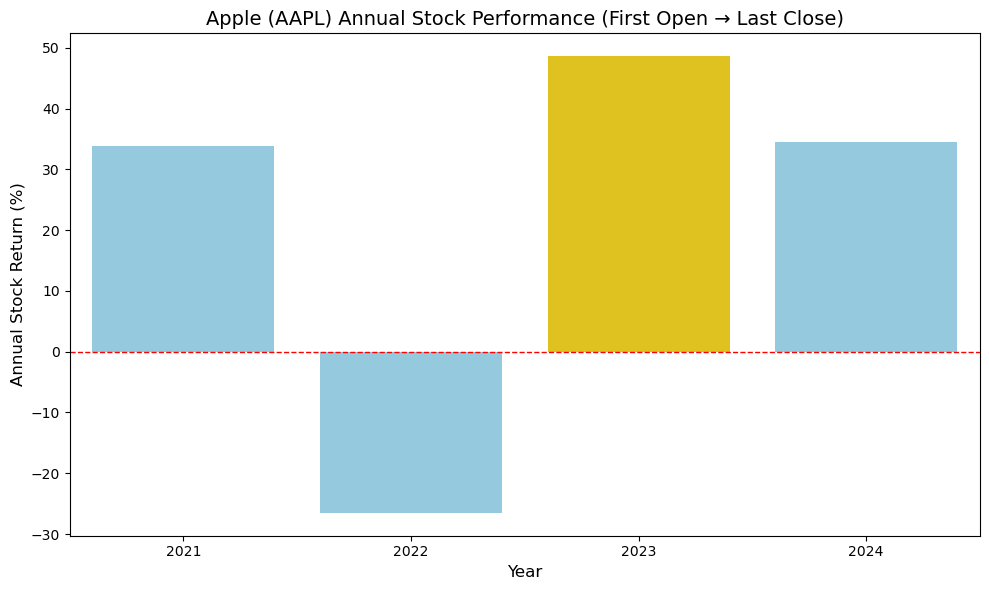


--- Annual Performance Analysis Complete ---
🥇 Best Stock Performance Year: 2023
   Return (First Open → Last Close): 48.61%

Products Released in that Year:
- Mac Mini with M2 Chip
- Mac Mini with M2 Pro chips
- HomePod (2nd Gen)
- MacBook Pro (14-inch and 16-inch) with M2 Pro and M2 Max chips
- Mac Pro with M2 Ultra chip
- Mac Studio with M2 Max and M2 Ultra chips
- MacBook Air (15 inch) with M2 chip
- Iphone 15
- Iphone 15 Plus
- Iphone 15 Pro
- Iphone 15 Pro Max
- AirPods Pro (2nd Gen) with USB-C Case
- Apple Watch Series 9
- Apple Watch Ultra 2
- Imac with M3 chip
- MacBook Pro (14-inch and 16-inch) with M3, M3 Pro, and M3 Max chips
- iMac (24-inch) with M3 chip

✅ Visualization saved as apple_annual_return.png


In [24]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
TICKER = "AAPL"
STOCK_DATA_PERIOD = "5y"
# Using the Excel file name you confirmed
EVENT_FILE_NAME = 'apple_release.xlsx' 

# --- 1. DOWNLOAD AND PREPARE STOCK DATA ---
print(f"Downloading {TICKER} stock data for the last {STOCK_DATA_PERIOD}...")
try:
    apple_stock_df = yf.download(TICKER, period=STOCK_DATA_PERIOD)
    
    # Flatten MultiIndex and lowercase columns
    apple_stock_df.columns = apple_stock_df.columns.get_level_values(0)
    apple_stock_df.columns = [col.lower() for col in apple_stock_df.columns]
    
    apple_stock_df = apple_stock_df.reset_index()
    apple_stock_df['Date'] = pd.to_datetime(apple_stock_df['Date'])
    
except Exception as e:
    print(f"⚠️ Error downloading stock data: {e}. Please ensure yfinance is installed and running.")
    raise

# --- 2. CALCULATE ANNUAL RETURN (First Open → Last Close) ---
print("Calculating annual returns (First Open to Last Close)...")
stock_df_reset = apple_stock_df.copy()
stock_df_reset['Year'] = stock_df_reset['Date'].dt.year

# Get the price on the first trading day of the year (Open)
first_open = stock_df_reset.groupby('Year').agg(
    first_open=('open', 'first')
).reset_index()

# Get the price on the last trading day of the year (Close)
last_close = stock_df_reset.groupby('Year').agg(
    last_close=('close', 'last')
).reset_index()

# Merge and calculate the annual return
annual_returns = pd.merge(first_open, last_close, on='Year')
annual_returns['Annual_Return_%'] = (
    (annual_returns['last_close'] - annual_returns['first_open']) / annual_returns['first_open']
) * 100

# Filter for full calendar years (excluding incomplete start/end years for a fair comparison)
full_years = annual_returns[
    (annual_returns['Year'] > stock_df_reset['Year'].min()) & 
    (annual_returns['Year'] < stock_df_reset['Year'].max())
].copy()

# --- 3. LOAD AND FILTER EVENT DATA ---
try:
    # Reading as Excel, as you confirmed the file name is 'apple_release.xlsx'
    events = pd.read_excel(EVENT_FILE_NAME) 
except FileNotFoundError:
    print(f"\n❌ FATAL ERROR: File '{EVENT_FILE_NAME}' not found. Cannot determine products. Check your file path!")
    raise

# Clean and filter event data
events.columns = events.columns.str.strip().str.lower()
events.rename(columns={'announcenment_date': 'announcement_date', 'product':'product'}, inplace=True)
events['release_date'] = pd.to_datetime(events['release_date'], dayfirst=True)
events['Release_Year'] = events['release_date'].dt.year

# --- 4. VISUALIZATION: Annual Return Bar Chart ---
plt.figure(figsize=(10, 6))
plot_data = full_years.sort_values('Year')

# Highlight the best year in a different color
best_year = full_years.loc[full_years['Annual_Return_%'].idxmax()]['Year']
colors = ['skyblue' if year != best_year else 'gold' for year in plot_data['Year']]

sns.barplot(
    data=plot_data,
    x='Year',
    y='Annual_Return_%',
    palette=colors
)

# Ensured all strings are properly closed with quotes
plt.title(f'Apple ({TICKER}) Annual Stock Performance (First Open → Last Close)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Annual Stock Return (%)', fontsize=12)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('apple_annual_return.png')

# THIS LINE DISPLAYS THE CHART IN JUPYTER LAB
plt.show() 

plt.close()

# --- 5. FINAL OUTPUT (Text Summary) ---
best_year_row = full_years.loc[full_years['Annual_Return_%'].idxmax()]
best_year_int = int(best_year_row['Year'])
best_return = best_year_row['Annual_Return_%']
products_in_best_year = events[events['Release_Year'] == best_year_int]['product'].unique()

print("\n--- Annual Performance Analysis Complete ---")
print(f"🥇 Best Stock Performance Year: {best_year_int}")
print(f"   Return (First Open → Last Close): {best_return:.2f}%")
print("\nProducts Released in that Year:")
for product in products_in_best_year:
    print(f"- {product.strip()}")
print("\n✅ Visualization saved as apple_annual_return.png")